### *This worksheet is for a simple catatrophe model that assesses the loss to assets (especially residential, commercial, industrial, retail, office etc. (data collected using OpenStreetMap)) due to cyclone (Haiyan (2013), Philippines). Data for Total Insured Value (TIV)/Asset Value is not known, so it was assumed 100000 USD to 1500000 USD overall range, however specific range is assumed for different asset types. To mimic meteorological conditions for the period ERA5 data is chosen for that period. Asset data may not be the real representations of assets or asset type in the region as it is an open source data from OpenStreetMap. ERA5 also may have some biases for the period and region of interest* ###

In [1]:
import pandas as pd
import geopandas as gpd
from hazard import open_and_prepare_dataset, identify_landfall
from vulnerability import get_osm_buildings
from exposure import calculate_losses
from plotting import create_interactive_map
from utils import print_cyclone_summary, write_loss_data_to_csv
from plotting import (plot_cyclone_features_at_landfall_point, create_loss_summary_plot)

### Download ERA5 data for a given cyclone period and region

In [2]:
ds = open_and_prepare_dataset(
    cyclone_name='Haiyan',
    north = 20.0,
    south = 5.0,
    east = 130.0,
    west = 115.0,
    start_date="2013-11-06",
    end_date="2013-11-11"
)
df = ds.to_dataframe().reset_index()
#### I already have data downloaded, if you don't have, you need to setup cdsapi in your environment

/home/jivesh/anaconda3/envs/pyenv/lib/python3.10/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cds-beta.climate.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/jivesh/anaconda3/envs/pyenv/lib/python3.10/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cds.climate.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
2025-01-07 17:17:52,798 INFO [2024-09-28T00:00:00] **Welcome to the New Climate Data Store (CDS)!** This new system is in its early days of full operations and still undergoing enhancements and fine tuning. Some disruptions are to be expected. Your 
[feedback](https://jira.ecmwf.int/plugins/servlet/desk/po

### Calculate landfall event. time, lat, lon, wind, wind gust, mslp and total precipitation and plot the parameters at the time of landfall

In [3]:
landfall_df = identify_landfall(df, method='max_wind') # or min_mslp
print_cyclone_summary(landfall_df)


--- Landfall Summary ---
Method of Detection  : max_wind
Wind Speed (kph)     : 104.2
Wind Gust (kph)      : 146.7
MSL (hPa)            : 990.6
Total Precipitation  : 12.5 mm
Latitude, Longitude  : 11.25, 126.25
Time                 : 2013-11-07 22:00:00
------------------------


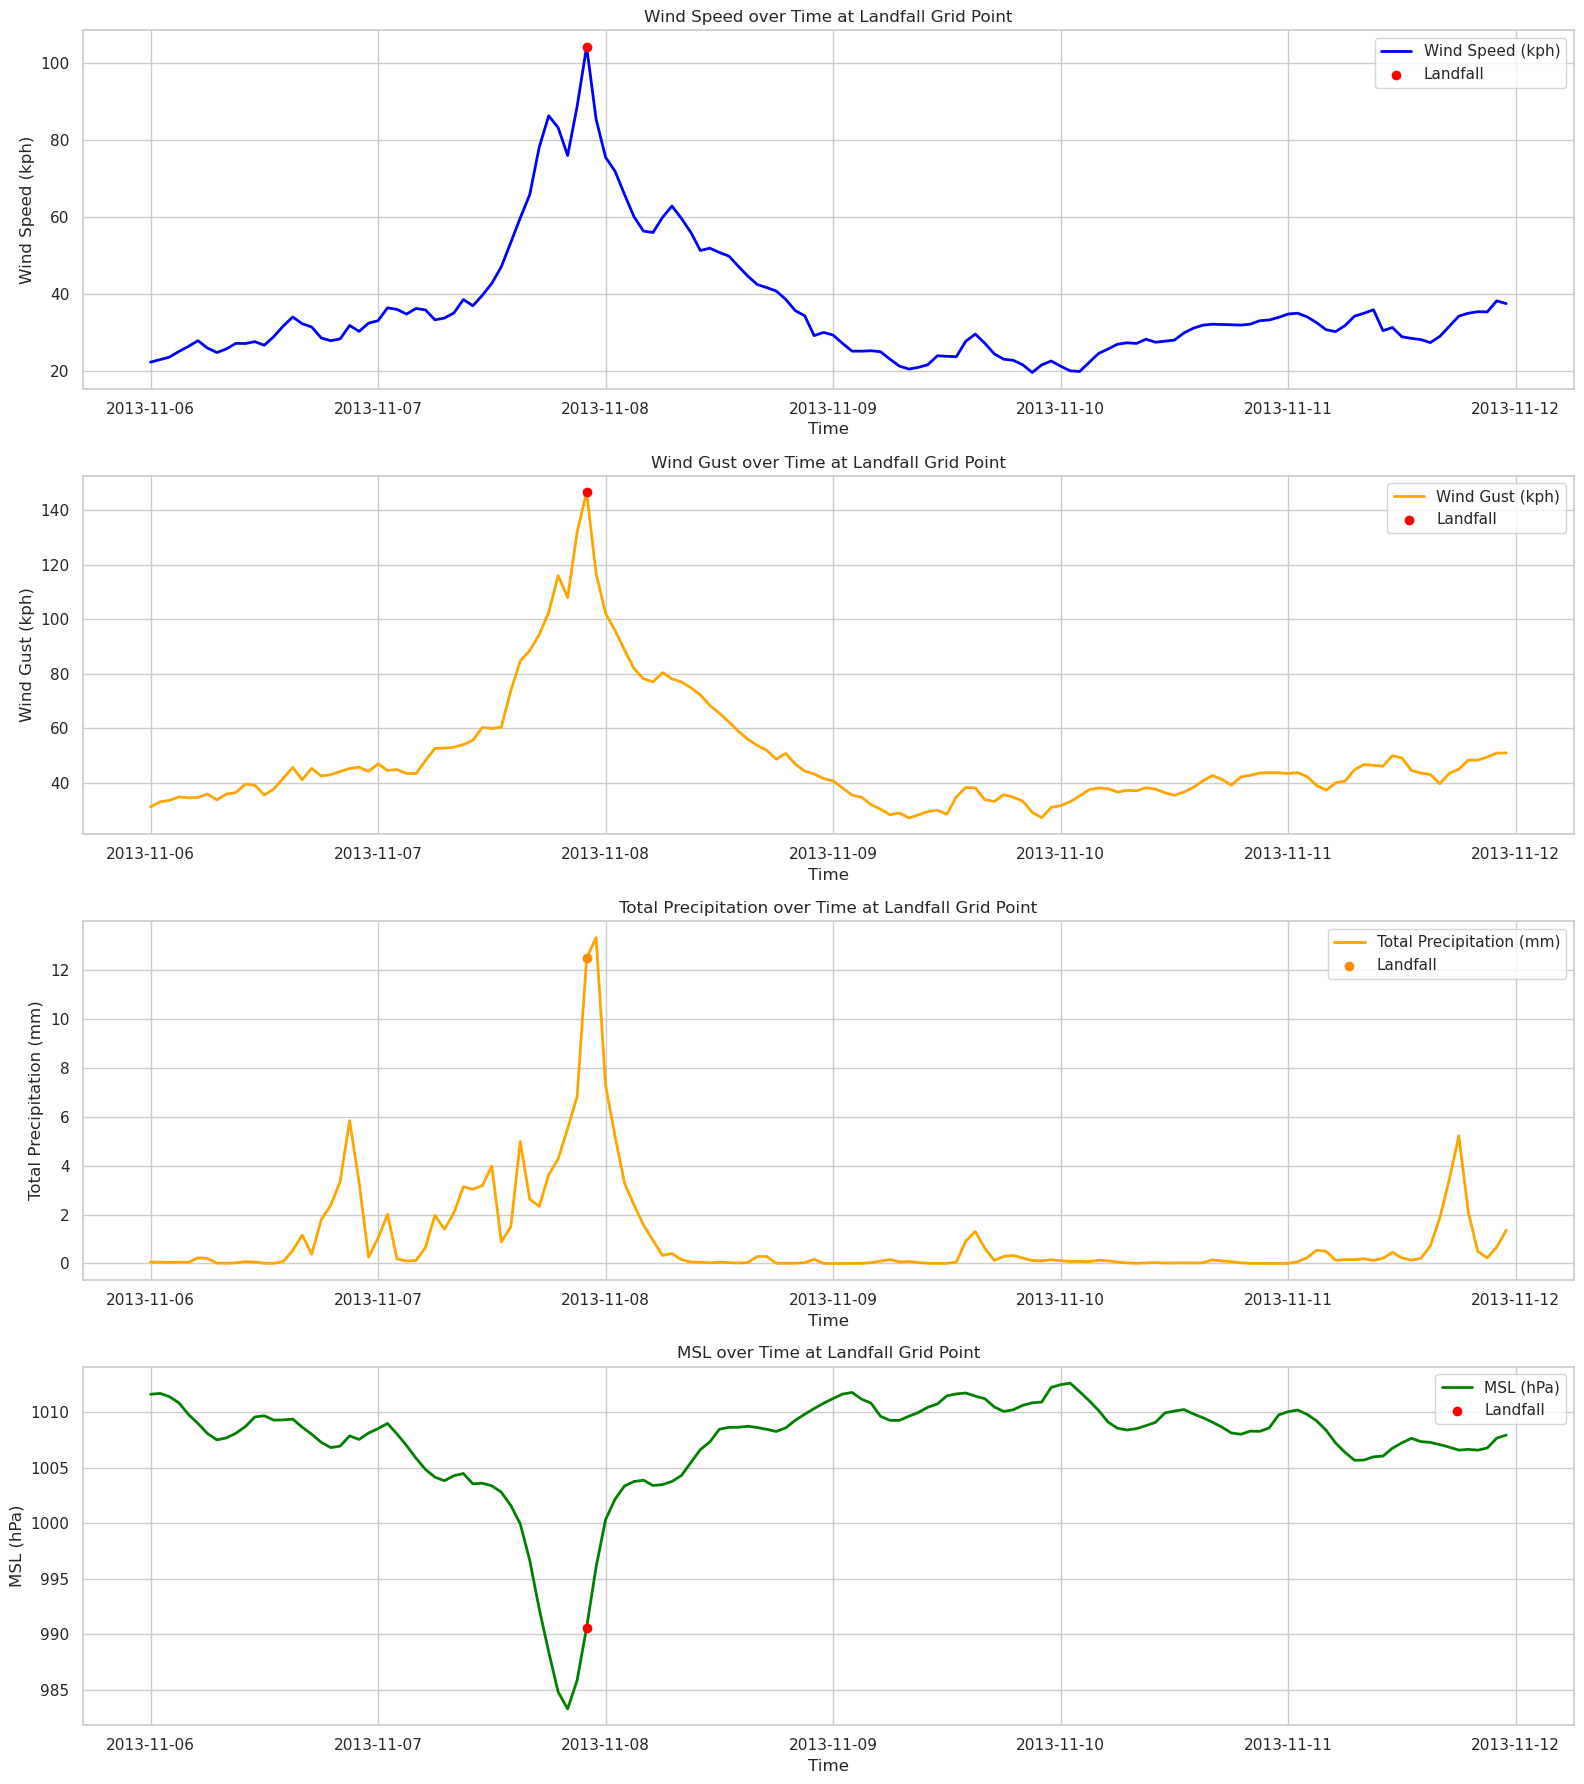

In [4]:
 plot_cyclone_features_at_landfall_point(df, landfall_df, 'Haiyan')

### Download the asset data in the form of geoDataFrame. In my case it is loaded using cached data ###

In [5]:
buildings_gdf = get_osm_buildings(
    place_name='Philippines',
    grid_size_km=100,
    parallel=True,
    max_workers=4,
    batch_size=10
)

Loading cached building data (GeoPackage)...
Total buildings loaded from cache: 138908


In [6]:
buildings_gdf

,addr_barangay,addr_city,addr_postcode,addr_province,Building_Type,name,shop,Grid_Cell_ID,addr_housenumber,addr_street,...,operator_abbr,source_accuracy,source_date,source_position,name_bg,Building_ID,Value_USD,Latitude,Longitude,geometry
0,Lanca,Mati City,8200,Davao Oriental,retail,SRD Water Refilling Station,water,5,None,None,...,None,None,None,None,None,d8c45da0-7650-49b1-bfda-eed528e1a03e,438247.875000,6.352094,126.197746,"POLYGON ((126.19772 6.35211, 126.19772 6.35208..."
1,None,None,8310,None,office,None,None,2,1,Hinatuan Legislative Building,...,None,None,None,None,None,d8c8f8bd-2289-4b66-9069-4a879f0feb17,788093.562500,8.367371,126.338593,"POLYGON ((126.33849 8.36744, 126.3386 8.36749,..."
2,None,None,None,None,retail,Hinatuan Public Market,None,2,None,None,...,None,None,None,None,None,fdde6f47-2a19-4fc2-9a72-eeb78d984d3d,645753.125000,8.365964,126.338524,"POLYGON ((126.3383 8.3659, 126.33863 8.36615, ..."
3,Poblacion,Bislig City,8311,Surigao del Sur,office,DepEd Bislig City Division Office,None,2,None,National Highway,...,None,None,None,None,None,34d25307-eb4e-4f49-827e-0d54e6d0cbdc,423641.593750,8.212579,126.315094,"POLYGON ((126.31511 8.2127, 126.31509 8.21261,..."
4,Poblacion,Bislig,8311,Surigao del Sur,retail,7-Eleven,convenience,2,None,None,...,None,None,None,None,None,d4015414-a32e-4329-a010-b0b69f84e493,424272.500000,8.212791,126.317017,"POLYGON ((126.31707 8.21288, 126.31704 8.21269..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138903,None,None,None,None,commercial,None,None,206,None,None,...,None,None,None,None,None,877e354c-6ebf-43d8-9097-f7527e1eb025,737031.187500,8.971707,117.999695,"POLYGON ((117.99978 8.97178, 117.99978 8.97164..."
138904,None,None,None,None,commercial,None,None,206,None,None,...,None,None,None,None,None,4c276ff4-17e3-40ef-b380-2f1d9274e8e6,336318.125000,8.971783,117.999344,"POLYGON ((117.99926 8.97183, 117.99925 8.97174..."
138905,None,None,None,None,commercial,None,None,206,None,None,...,None,None,None,None,None,d2e24fa2-9723-4f44-81c6-970dcf71d283,701272.437500,8.971788,117.999107,"POLYGON ((117.99899 8.97184, 117.99899 8.97175..."
138906,None,None,None,None,commercial,South Palawan Planning & Management Center,None,206,None,None,...,None,None,None,None,None,b2ea4871-0a68-4711-a9d0-aa6df8e83de5,240886.968750,8.971165,117.997955,"POLYGON ((117.99802 8.97131, 117.99803 8.97099..."


### Calculating total loss and loss to each asset seperately and save data for assets that faced losses during the event.

In [7]:
loss_df, updated_assets_gdf = calculate_losses(buildings_gdf, landfall_df, radius_km=150)

In [8]:
write_loss_data_to_csv(updated_assets_gdf, output_filename=f"Haiyan_losses.csv")

Loss data written to Haiyan_losses.csv


In [9]:
loss_df

,Cyclone_ID,Wind_Speed_kph,Wind_Gust_kph,Total_Precip_mm,Latitude,Longitude,Total_Loss_USD
0,1,104.158722,146.652969,12.488842,11.25,126.25,2494956.5


In [10]:
updated_assets_gdf

,addr_barangay,addr_city,addr_postcode,addr_province,Building_Type,name,shop,Grid_Cell_ID,addr_housenumber,addr_street,...,Building_ID,Value_USD,Latitude,Longitude,geometry,Distance_km,Damage_Wind_Speed_%,Damage_Precipitation_%,Combined_Damage_%,Loss_USD
0,Lanca,Mati City,8200,Davao Oriental,retail,SRD Water Refilling Station,water,5,None,None,...,d8c45da0-7650-49b1-bfda-eed528e1a03e,438247.875000,6.352094,126.197746,"POLYGON ((126.19772 6.35211, 126.19772 6.35208...",761.746966,0.0,0.0,0.0,0.0
1,None,None,8310,None,office,None,None,2,1,Hinatuan Legislative Building,...,d8c8f8bd-2289-4b66-9069-4a879f0feb17,788093.562500,8.367371,126.338593,"POLYGON ((126.33849 8.36744, 126.3386 8.36749,...",447.932319,0.0,0.0,0.0,0.0
2,None,None,None,None,retail,Hinatuan Public Market,None,2,None,None,...,fdde6f47-2a19-4fc2-9a72-eeb78d984d3d,645753.125000,8.365964,126.338524,"POLYGON ((126.3383 8.3659, 126.33863 8.36615, ...",448.141365,0.0,0.0,0.0,0.0
3,Poblacion,Bislig City,8311,Surigao del Sur,office,DepEd Bislig City Division Office,None,2,None,National Highway,...,34d25307-eb4e-4f49-827e-0d54e6d0cbdc,423641.593750,8.212579,126.315094,"POLYGON ((126.31511 8.2127, 126.31509 8.21261,...",471.870779,0.0,0.0,0.0,0.0
4,Poblacion,Bislig,8311,Surigao del Sur,retail,7-Eleven,convenience,2,None,None,...,d4015414-a32e-4329-a010-b0b69f84e493,424272.500000,8.212791,126.317017,"POLYGON ((126.31707 8.21288, 126.31704 8.21269...",471.860281,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138903,None,None,None,None,commercial,None,None,206,None,None,...,877e354c-6ebf-43d8-9097-f7527e1eb025,737031.187500,8.971707,117.999695,"POLYGON ((117.99978 8.97178, 117.99978 8.97164...",1235.610721,0.0,0.0,0.0,0.0
138904,None,None,None,None,commercial,None,None,206,None,None,...,4c276ff4-17e3-40ef-b380-2f1d9274e8e6,336318.125000,8.971783,117.999344,"POLYGON ((117.99926 8.97183, 117.99925 8.97174...",1235.653364,0.0,0.0,0.0,0.0
138905,None,None,None,None,commercial,None,None,206,None,None,...,d2e24fa2-9723-4f44-81c6-970dcf71d283,701272.437500,8.971788,117.999107,"POLYGON ((117.99899 8.97184, 117.99899 8.97175...",1235.679933,0.0,0.0,0.0,0.0
138906,None,None,None,None,commercial,South Palawan Planning & Management Center,None,206,None,None,...,b2ea4871-0a68-4711-a9d0-aa6df8e83de5,240886.968750,8.971165,117.997955,"POLYGON ((117.99802 8.97131, 117.99803 8.97099...",1235.859906,0.0,0.0,0.0,0.0


### Plotting total loss for the event

/home/jivesh/Catestrophe_model/catastrophe_model/plotting.py:117: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=loss_df, x='Cyclone_ID', y='Total_Loss_USD', palette='viridis', width=0.6)


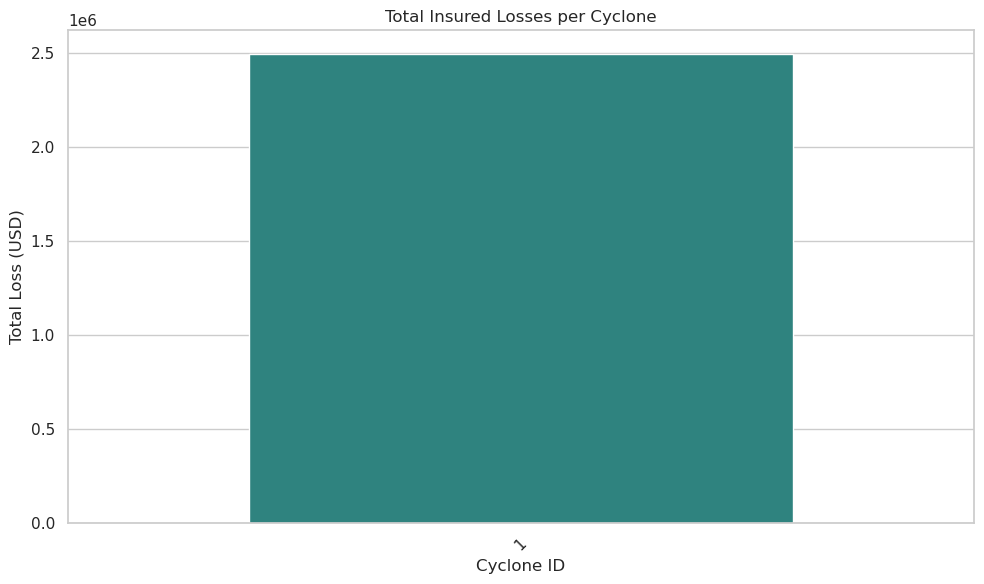

In [11]:
create_loss_summary_plot(loss_df, 'Haiyan')

In [12]:
# Optionally merge total loss into landfall_df so the map can display it

if not loss_df.empty and "Cyclone_ID" in landfall_df.columns:
    # Optionally merge total loss into landfall_df so the map can display it
    loss_df_unique = loss_df.drop_duplicates(subset=['Cyclone_ID'])
    landfall_df = pd.merge(
        landfall_df,
        loss_df_unique[['Cyclone_ID', 'Total_Loss_USD', 'Total_Precip_mm']],
        on='Cyclone_ID',
        how='left'
    )

### Creating interactive map of all assets, with and without loss 

In [13]:
create_interactive_map('Haiyan',
    assets_gdf=updated_assets_gdf,
    cyclone_df=landfall_df,
    radius_km=150
)

### Plotting the interactive map

In [14]:
from IPython.display import IFrame

IFrame(src="hurricane_Haiyan_map.html", width=1000, height=500)